# FFNN Fraud Detection - Complete Pipeline

This notebook demonstrates the complete Feed-Forward Neural Network (FFNN) pipeline for fraud detection, from data loading to hyperparameter tuning.

## Pipeline Overview:
1. **Library Setup** - Import PyTorch, pandas, and custom FFNN models
2. **Workspace Check** - Verify data directory structure
3. **Data Loading & Feature Engineering** - Load dataset and create enhanced features
4. **Data Preprocessing** - Scaling, stratified splits, and class balancing
5. **Single Model Training** - Train baseline FFNN configuration
6. **Results Analysis** - Interpret business metrics and model performance
7. **Hyperparameter Tuning** - Grid search for optimal parameters
8. **Tuning Analysis** - Compare configurations and parameter effects
9. **Model Deployment** - Load and use best model for predictions

## Business Context:
- **False Positive Cost**: $540 (blocking legitimate transaction)
- **False Negative Cost**: $110 (missing fraud, average fraud amount)
- **Goal**: Minimize total business cost while maintaining good fraud detection

## 1. Import Required Libraries

Import all necessary libraries including PyTorch, pandas, numpy, matplotlib, and our custom FFNN models.

In [2]:
# pip install kaggle

In [4]:
# Core libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Scikit-learn utilities
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.preprocessing import StandardScaler

# Additional utilities
from pathlib import Path

# Add project root to path for importing custom modules
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

# Import our custom FFNN models
from src.ffnn_models import (
    FFNNDataHandler,
    FraudDetectionFFNN,
    FFNNFraudTrainer,
    FFNNGridSearchTuner,
    ThresholdOptimizer,
    compute_prediction_scores
)

# Check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

Using device: cpu
PyTorch version: 2.9.0


## 2. Load Dataset from Workspace

Load the credit card fraud dataset from your existing workspace data directory.

In [6]:
# Check your workspace data directory structure
print("=== WORKSPACE DATA DIRECTORY CHECK ===")

# Data paths - define here for workspace check
DATA_RAW_PATH = '../data/raw/creditcard.csv'
DATA_PROCESSED_PATH = '../data/processed/creditcard_fe.csv'

# Expected directory structure
expected_dirs = ['../data', '../data/raw', '../data/processed']
for dir_path in expected_dirs:
    if os.path.exists(dir_path):
        print(f"✅ {dir_path} exists")
        # List files in data directories
        if 'raw' in dir_path or 'processed' in dir_path:
            files = [f for f in os.listdir(dir_path) if f.endswith('.csv')]
            if files:
                print(f"   📁 CSV files found: {files}")
            else:
                print(f"   📁 No CSV files found")
    else:
        print(f"❌ {dir_path} not found")

print(f"\n📋 Expected dataset files:")
print(f"   • Raw data: {DATA_RAW_PATH}")
print(f"   • Processed data: {DATA_PROCESSED_PATH}")
print(f"\n💡 If dataset not found, download from:")
print(f"   https://www.kaggle.com/mlg-ulb/creditcardfraud")

=== WORKSPACE DATA DIRECTORY CHECK ===
✅ ../data exists
✅ ../data/raw exists
   📁 CSV files found: ['creditcard.csv']
✅ ../data/processed exists
   📁 CSV files found: ['creditcard_fe.csv']

📋 Expected dataset files:
   • Raw data: ../data/raw/creditcard.csv
   • Processed data: ../data/processed/creditcard_fe.csv

💡 If dataset not found, download from:
   https://www.kaggle.com/mlg-ulb/creditcardfraud


## 3. Load Credit Card Fraud Dataset

Load the Credit Card Fraud Detection dataset from your workspace data directory.

**Dataset**: [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud)

The notebook will:
1. First check for existing processed data (`../data/processed/creditcard_fe.csv`)
2. Then check for existing raw data (`../data/raw/creditcard.csv`)
3. Provide download instructions if dataset not found

In [8]:
# Data paths - using your existing workspace structure
DATA_RAW_PATH = '../data/raw/creditcard.csv'
DATA_PROCESSED_PATH = '../data/processed/creditcard_fe.csv'
DATA_DIR = '../data'

# Check for existing data in your workspace
if os.path.exists(DATA_PROCESSED_PATH):
    print(f"Loading processed data from: {DATA_PROCESSED_PATH}")
    df = pd.read_csv(DATA_PROCESSED_PATH)
    data_path = DATA_PROCESSED_PATH
elif os.path.exists(DATA_RAW_PATH):
    print(f"Loading raw data from: {DATA_RAW_PATH}")
    df = pd.read_csv(DATA_RAW_PATH)
    data_path = DATA_RAW_PATH
else:
    print("Dataset not found in your workspace!")
    print("Available options:")
    print("1. Place 'creditcard.csv' in '../data/raw/' directory")
    print("2. Place processed 'creditcard_fe.csv' in '../data/processed/' directory")
    print("3. Download from: https://www.kaggle.com/mlg-ulb/creditcardfraud")
    raise FileNotFoundError("Credit card dataset not found in workspace")

print(f"\nDataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"Data source: {data_path}")

Loading processed data from: ../data/processed/creditcard_fe.csv

Dataset loaded successfully!
Shape: (284807, 37)
Memory usage: 80.4 MB
Data source: ../data/processed/creditcard_fe.csv


In [11]:
# Explore dataset structure
print("=== DATASET OVERVIEW ===")
print(f"Number of samples: {len(df):,}")
print(f"Number of features: {df.shape[1]}")
print(f"Data types:")
print(df.dtypes.value_counts())

print(f"\n=== CLASS DISTRIBUTION ===")
class_counts = df['Class'].value_counts()
print(f"Normal transactions (Class 0): {class_counts[0]:,} ({class_counts[0]/len(df)*100:.2f}%)")
print(f"Fraud transactions (Class 1): {class_counts[1]:,} ({class_counts[1]/len(df)*100:.2f}%)")
print(f"Fraud rate: {class_counts[1]/len(df)*100:.3f}%")

print(f"\n=== MISSING VALUES ===")
missing_counts = df.isnull().sum()
print(f"Total missing values: {missing_counts.sum()}")
if missing_counts.sum() > 0:
    print("Columns with missing values:")
    print(missing_counts[missing_counts > 0])
else:
    print("No missing values found ✓")

print(f"\n=== FEATURE COLUMNS ===")
feature_cols = [col for col in df.columns if col != 'Class']
print(f"Features: {len(feature_cols)}")
print(f"Feature names: {feature_cols}")

=== DATASET OVERVIEW ===
Number of samples: 284,807
Number of features: 37
Data types:
float64    34
int64       3
Name: count, dtype: int64

=== CLASS DISTRIBUTION ===
Normal transactions (Class 0): 284,315 (99.83%)
Fraud transactions (Class 1): 492 (0.17%)
Fraud rate: 0.173%

=== MISSING VALUES ===
Total missing values: 0
No missing values found ✓

=== FEATURE COLUMNS ===
Features: 36
Feature names: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Hour', 'Hour_sin', 'Day', 'log_Amount', 'Time_bin', 'Amount_bin']


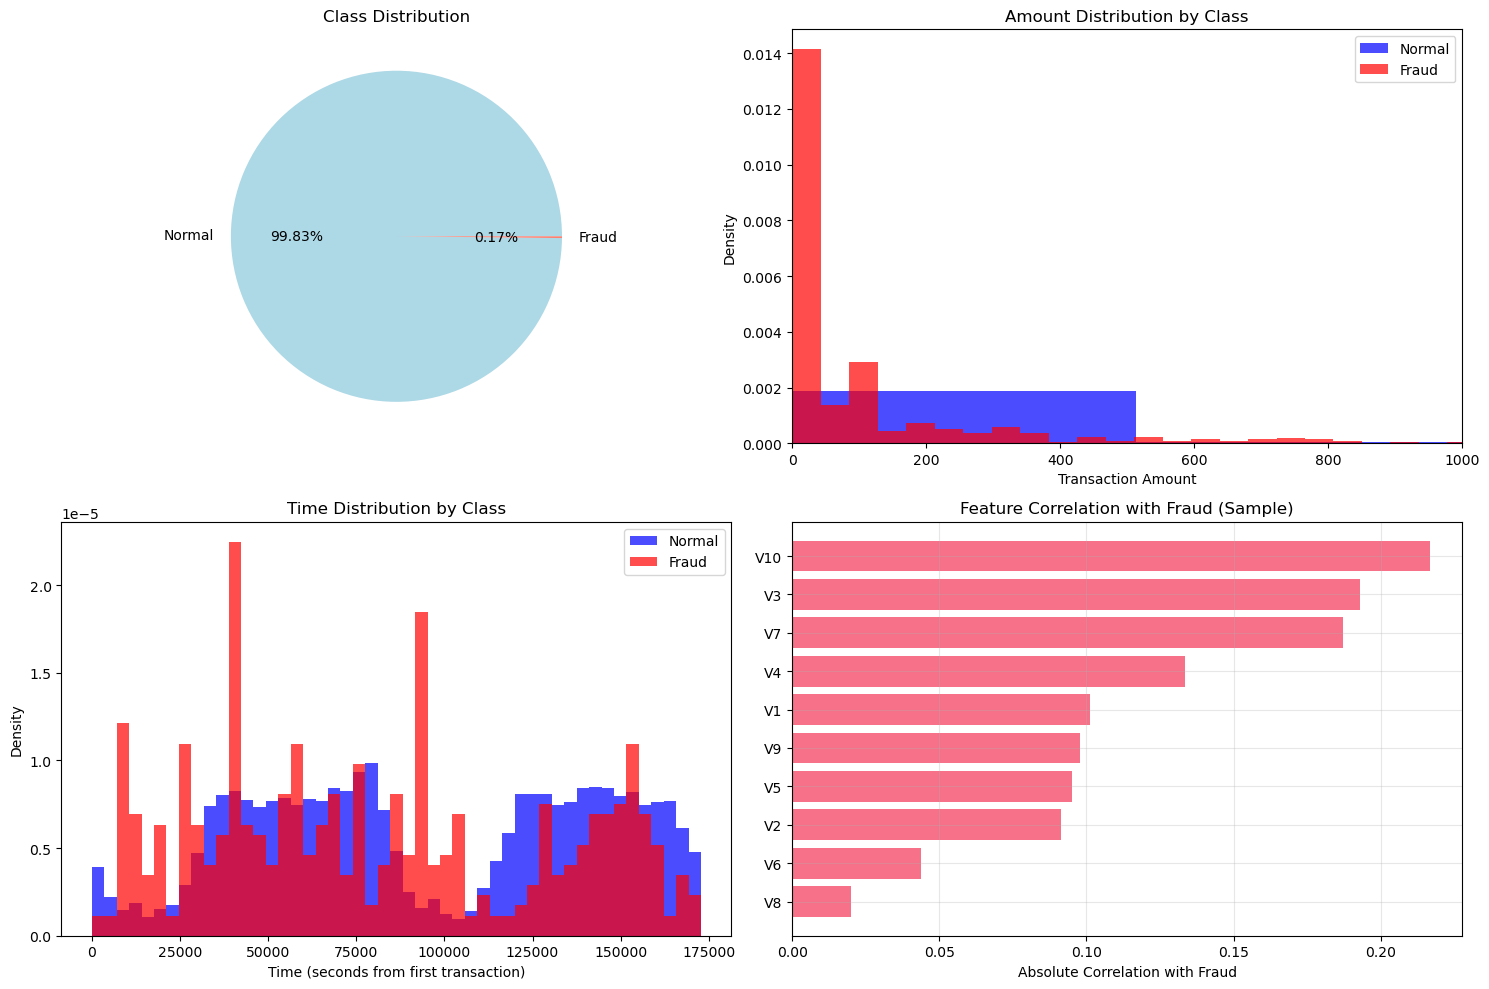


=== KEY INSIGHTS ===
• Dataset is highly imbalanced (0.173% fraud)
• Total economic impact of fraud: $60,128
• Average fraud amount: $122
• This justifies our business costs: $550 (FP) vs $110 (FN)


In [12]:
# Visualize class distribution and key statistics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Class distribution
axes[0, 0].pie(class_counts.values, labels=['Normal', 'Fraud'], autopct='%1.2f%%', 
               colors=['lightblue', 'salmon'])
axes[0, 0].set_title('Class Distribution')

# Amount distribution by class
if 'Amount' in df.columns:
    axes[0, 1].hist(df[df['Class']==0]['Amount'], bins=50, alpha=0.7, 
                   label='Normal', color='blue', density=True)
    axes[0, 1].hist(df[df['Class']==1]['Amount'], bins=50, alpha=0.7, 
                   label='Fraud', color='red', density=True)
    axes[0, 1].set_xlabel('Transaction Amount')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].set_title('Amount Distribution by Class')
    axes[0, 1].legend()
    axes[0, 1].set_xlim(0, 1000)  # Focus on main range

# Time distribution (if available)
if 'Time' in df.columns:
    time_bins = np.linspace(0, df['Time'].max(), 50)
    axes[1, 0].hist(df[df['Class']==0]['Time'], bins=time_bins, alpha=0.7, 
                   label='Normal', color='blue', density=True)
    axes[1, 0].hist(df[df['Class']==1]['Time'], bins=time_bins, alpha=0.7, 
                   label='Fraud', color='red', density=True)
    axes[1, 0].set_xlabel('Time (seconds from first transaction)')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].set_title('Time Distribution by Class')
    axes[1, 0].legend()

# Feature correlation with fraud (sample of V features)
v_features = [col for col in df.columns if col.startswith('V')][:10]  # First 10 V features
correlations = df[v_features + ['Class']].corr()['Class'][:-1].abs().sort_values(ascending=True)
axes[1, 1].barh(range(len(correlations)), correlations.values)
axes[1, 1].set_yticks(range(len(correlations)))
axes[1, 1].set_yticklabels(correlations.index)
axes[1, 1].set_xlabel('Absolute Correlation with Fraud')
axes[1, 1].set_title('Feature Correlation with Fraud (Sample)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=== KEY INSIGHTS ===")
print(f"• Dataset is highly imbalanced ({class_counts[1]/len(df)*100:.3f}% fraud)")
print(f"• Total economic impact of fraud: ${df[df['Class']==1]['Amount'].sum():,.0f}" if 'Amount' in df.columns else "")
print(f"• Average fraud amount: ${df[df['Class']==1]['Amount'].mean():.0f}" if 'Amount' in df.columns else "")
print(f"• This justifies our business costs: $540 (FP) vs $110 (FN)")

## 3.5. Feature Engineering

Enhance the raw credit card dataset with additional time-based and amount-based features to improve fraud detection performance.

**Enhanced Features**:
- **Time Features**: Hour of day, cyclical encodings for temporal patterns
- **Amount Features**: Log transformation and categorical groupings
- **Target**: Maintain original Class column for fraud detection

This step automatically creates the processed dataset (`creditcard_fe.csv`) if it doesn't exist.

In [17]:
# Feature Engineering Functions
def perform_feature_engineering(df):
    """
    Apply feature engineering to raw creditcard data.
    
    Creates time-based and amount-based features needed for the FFNN models.
    This function replicates the logic from notebooks/eda/EDA_named_features_analysis_FE.ipynb
    
    Args:
        df: DataFrame with raw creditcard data containing 'Time' and 'Amount' columns
    
    Returns:
        DataFrame with engineered features added
    """
    print("=== APPLYING FEATURE ENGINEERING ===")
    print("Creating enhanced features from Time and Amount columns...")
    
    # Make a copy to avoid modifying original
    df_fe = df.copy()
    
    # 1. Hour: Extract hour from Time (seconds elapsed)
    # Time is in seconds, so divide by 3600 to get hours, then mod 24 for hour of day
    df_fe['Hour'] = (df_fe['Time'] // 3600) % 24
    print("  ✓ Hour: Extracted hour of day (0-23) from Time")
    
    # 2. Hour_sin: Cyclical encoding of hour using sine transformation
    # Hours are cyclical (0-23 wraps around), so use sine to capture this
    df_fe['Hour_sin'] = np.sin(2 * np.pi * df_fe['Hour'] / 24)
    print("  ✓ Hour_sin: Applied cyclical encoding using sine transformation")
    
    # 3. Day: Extract day number from Time
    df_fe['Day'] = df_fe['Time'] // (3600 * 24)
    print("  ✓ Day: Extracted day number from Time")
    
    # 4. log_Amount: Log transformation of Amount to handle skewness
    # Add small epsilon to avoid log(0) issues
    df_fe['log_Amount'] = np.log(df_fe['Amount'] + 1e-6)
    print("  ✓ log_Amount: Applied log transformation to handle skewness")
    
    # 5. Time_bin: Categorize time of day
    # 0-6: Night, 6-12: Morning, 12-18: Afternoon, 18-24: Evening
    time_bins = pd.cut(
        df_fe['Hour'],
        bins=[0, 6, 12, 18, 24],
        labels=['Night', 'Morning', 'Afternoon', 'Evening'],
        right=False
    )
    # Convert to numeric codes: Night=0, Morning=1, Afternoon=2, Evening=3
    df_fe['Time_bin'] = time_bins.cat.codes
    print("  ✓ Time_bin: Created time of day categories (0=Night, 1=Morning, 2=Afternoon, 3=Evening)")
    
    # 6. Amount_bin: Categorize amount by quantiles
    # Split into 3 bins: Low, Medium, High based on quantiles
    amount_bins = pd.qcut(
        df_fe['Amount'],
        q=3,
        labels=['Low', 'Medium', 'High']
    )
    # Convert to numeric codes: Low=0, Medium=1, High=2
    df_fe['Amount_bin'] = amount_bins.cat.codes
    print("  ✓ Amount_bin: Created amount categories (0=Low, 1=Medium, 2=High)")
    
    print(f"\nFeature engineering complete!")
    print(f"  Original features: {len(df.columns)}")
    print(f"  Enhanced features: {len(df_fe.columns)}")
    print(f"  New features added: Hour, Hour_sin, Day, log_Amount, Time_bin, Amount_bin")
    
    return df_fe

def check_and_apply_feature_engineering(data_path):
    """
    Check if data needs feature engineering and apply if necessary.
    
    Args:
        data_path: Path to the dataset (raw or processed)
    
    Returns:
        DataFrame with feature engineering applied (if needed)
    """
    df = pd.read_csv(data_path)
    
    # Check if feature engineering is needed
    required_features = ['Hour', 'Hour_sin', 'log_Amount']
    missing_features = [feat for feat in required_features if feat not in df.columns]
    
    if missing_features:
        print(f"Missing enhanced features: {missing_features}")
        print("Applying feature engineering to raw data...")
        df_enhanced = perform_feature_engineering(df)
        
        # Save processed data for future use
        processed_path = '../data/processed/creditcard_fe.csv'
        os.makedirs(os.path.dirname(processed_path), exist_ok=True)
        df_enhanced.to_csv(processed_path, index=False)
        print(f"Enhanced dataset saved to: {processed_path}")
        
        return df_enhanced
    else:
        print("Dataset already contains enhanced features ✓")
        return df

## 4. Data Preprocessing and Setup

Set up the FFNNDataHandler to handle data loading, feature dropping, and train/validation/test splits. We'll use the 'logreg_baseline' preset to match features used in logistic regression baseline.

In [20]:
# Apply feature engineering if needed
print("=== FEATURE ENGINEERING CHECK ===")
df_enhanced = check_and_apply_feature_engineering(data_path)

# Update data_path to use enhanced dataset
if 'Hour' not in df.columns and 'Hour' in df_enhanced.columns:
    # Feature engineering was applied, update path to processed data
    data_path = '../data/processed/creditcard_fe.csv'
    print(f"Using enhanced dataset: {data_path}")

# Configuration for data preprocessing
DATA_CONFIG = {
    'data_path': data_path,
    'drop_features': 'logreg_baseline',  # Use same features as logistic regression
    'test_size': 0.2,      # 20% for test set
    'val_size': 0.25,       # 20% for validation  
    'random_seed': 42      # For reproducibility
}

print("\n=== DATA PREPROCESSING SETUP ===")
print(f"Data source: {DATA_CONFIG['data_path']}")
print(f"Feature dropping preset: {DATA_CONFIG['drop_features']}")
print(f"Data splits: {100-DATA_CONFIG['test_size']*100:.0f}% train+val, {DATA_CONFIG['test_size']*100:.0f}% test")
print(f"Validation: {DATA_CONFIG['val_size']*100:.0f}% of train+val")
print(f"Random seed: {DATA_CONFIG['random_seed']}")

# Initialize data handler
data_handler = FFNNDataHandler(
    data_path=DATA_CONFIG['data_path'],
    random_seed=DATA_CONFIG['random_seed'],
    drop_features=DATA_CONFIG['drop_features'],
    test_size=DATA_CONFIG['test_size'],
    val_size=DATA_CONFIG['val_size']
)

# Load and split data
print(f"\n=== LOADING AND SPLITTING DATA ===")
data = data_handler.load_and_split()

print(f"\n=== PREPROCESSING (SCALING) ===")
X_train_scaled, X_val_scaled, X_test_scaled = data_handler.preprocess(
    data['X_train'], data['X_val'], data['X_test']
)

print(f"\n=== FINAL DATA SUMMARY ===")
print(f"Input dimensions: {data['input_dim']}")
print(f"Feature names available: {len(data_handler.get_feature_names())}")
print(f"Class weights: {data['class_weights']}")
print(f"Scaling complete: Mean ≈ {X_train_scaled.mean():.3f}, Std ≈ {X_train_scaled.std():.3f}")

=== FEATURE ENGINEERING CHECK ===
Dataset already contains enhanced features ✓

=== DATA PREPROCESSING SETUP ===
Data source: ../data/processed/creditcard_fe.csv
Feature dropping preset: logreg_baseline
Data splits: 80% train+val, 20% test
Validation: 25% of train+val
Random seed: 42

=== LOADING AND SPLITTING DATA ===
Loading data from ../data/processed/creditcard_fe.csv...
Dataset loaded: 284807 rows, features: 22
  Normal: 284315 | Fraud: 492
  Fraud rate: 0.17%
  Class weights: {0: 0.5008652375006595, 1: 289.4380081300813}

Data split:
  Training: 156643 samples (271 fraud)
  Validation: 71202 samples (123 fraud)
  Test: 56962 samples (98 fraud)

=== PREPROCESSING (SCALING) ===
Data normalized:
  Train mean: 0.0000, std: 1.0000
  Val mean: 0.0003, std: 1.0033

=== FINAL DATA SUMMARY ===
Input dimensions: 22
Feature names available: 22
Class weights: {0: 0.5008652375006595, 1: 289.4380081300813}
Scaling complete: Mean ≈ 0.000, Std ≈ 1.000


## 5. Single FFNN Model Training

Configure and train a single FFNN model with baseline hyperparameters. This demonstrates the complete training workflow including early stopping, threshold optimization, and evaluation.

In [22]:
# Configuration for single model training
SINGLE_MODEL_CONFIG = {
    # Data
    'data_path': data_path,
    'drop_features': 'logreg_baseline',
    'test_size': 0.2,
    'val_size': 0.2,
    'random_seed': 42,
    
    # Model architecture
    'hidden_dim': 128,
    'dropout_rate': 0.2,
    
    # Training
    'learning_rate': 0.001,
    'batch_size': 64,
    'epochs': 100,
    'patience': 15,  # Early stopping patience
    'use_class_weights': True,  # Handle class imbalance
    
    # Business costs
    'C_FP': 540,  # Cost per false positive
    'C_FN': 110,  # Cost per false negative
    
    # Hardware
    'device': device,
    
    # Output paths
    'model_save_path': '../models/ffnn_single_baseline.pth',
    'results_save_path': '../results/figures/ffnn_single_baseline.png'
}

print("=== SINGLE MODEL CONFIGURATION ===")
print("Architecture:")
print(f"  Hidden dimension: {SINGLE_MODEL_CONFIG['hidden_dim']}")
print(f"  Dropout rate: {SINGLE_MODEL_CONFIG['dropout_rate']}")
print(f"  Expected architecture: {data['input_dim']} → {SINGLE_MODEL_CONFIG['hidden_dim']} → {SINGLE_MODEL_CONFIG['hidden_dim']//2} → {SINGLE_MODEL_CONFIG['hidden_dim']//4} → 1")

print(f"\nTraining:")
print(f"  Learning rate: {SINGLE_MODEL_CONFIG['learning_rate']}")
print(f"  Batch size: {SINGLE_MODEL_CONFIG['batch_size']}")
print(f"  Max epochs: {SINGLE_MODEL_CONFIG['epochs']}")
print(f"  Early stopping patience: {SINGLE_MODEL_CONFIG['patience']}")
print(f"  Class weights: {SINGLE_MODEL_CONFIG['use_class_weights']}")

print(f"\nBusiness costs:")
print(f"  False positive: ${SINGLE_MODEL_CONFIG['C_FP']}")
print(f"  False negative: ${SINGLE_MODEL_CONFIG['C_FN']}")

print(f"\nDevice: {SINGLE_MODEL_CONFIG['device']}")

=== SINGLE MODEL CONFIGURATION ===
Architecture:
  Hidden dimension: 128
  Dropout rate: 0.2
  Expected architecture: 22 → 128 → 64 → 32 → 1

Training:
  Learning rate: 0.001
  Batch size: 64
  Max epochs: 100
  Early stopping patience: 15
  Class weights: True

Business costs:
  False positive: $550
  False negative: $110

Device: cpu


In [23]:
# Create and train the model
print("=== TRAINING SINGLE FFNN MODEL ===")
print("Starting training... (this may take a few minutes)")

# Create trainer
trainer = FFNNFraudTrainer(SINGLE_MODEL_CONFIG)

# Train the model (this runs the complete 6-step pipeline)
start_time = datetime.now()
test_results = trainer.run()
end_time = datetime.now()
training_time = (end_time - start_time).total_seconds()

print(f"\n=== TRAINING COMPLETED ===")
print(f"Training time: {training_time/60:.1f} minutes")
print(f"Model saved to: {SINGLE_MODEL_CONFIG['model_save_path']}")
print(f"Visualizations saved to: {SINGLE_MODEL_CONFIG['results_save_path']}")

=== TRAINING SINGLE FFNN MODEL ===
Starting training... (this may take a few minutes)
FFNN FRAUD DETECTION TRAINING

[1/6] Loading and preparing data...
Loading data from ../data/processed/creditcard_fe.csv...
Dataset loaded: 284807 rows, features: 22
  Normal: 284315 | Fraud: 492
  Fraud rate: 0.17%
  Class weights: {0: 0.5008652375006595, 1: 289.4380081300813}

Data split:
  Training: 170883 samples (295 fraud)
  Validation: 56962 samples (99 fraud)
  Test: 56962 samples (98 fraud)

[2/6] Scaling features...
Data normalized:
  Train mean: 0.0000, std: 1.0000
  Val mean: 0.0001, std: 1.0046
PyTorch DataLoaders created:
  Train batches: 2671
  Val batches: 891
  Test batches: 891

[3/6] Building model...
Model architecture: 22 → 128 → 64 → 32 → 1
Total trainable parameters: 13,313

[4/6] Training FFNN on CPU...
Using BCE loss (class weight ratio: 577.88)
Epoch 10/100 - Train Loss: 0.0021, Train Acc: 99.95% | Val Loss: 0.0039, Val Acc: 99.92%

Early stopping triggered at epoch 19

Train

## 6. Model Evaluation and Results Interpretation

Analyze the trained model's performance, interpret business metrics, and understand what the results mean for fraud detection.

In [27]:
# Display comprehensive results analysis
print("=== SINGLE MODEL RESULTS ANALYSIS ===")

# Training performance
print(f"\nTraining Performance:")
print(f"  Total epochs trained: {len(trainer.train_losses)}")
print(f"  Final training loss: {trainer.train_losses[-1]:.4f}")
print(f"  Final validation loss: {trainer.val_losses[-1]:.4f}")
print(f"  Best validation cost: ${trainer.val_cost:,.0f}")
print(f"  Optimal threshold: {trainer.optimal_threshold:.3f}")

# Test set results
print(f"\nTest Set Performance:")
print(f"  Total business cost: ${test_results['total_cost']:,.0f}")
print(f"  Baseline cost (no detection): ${test_results['baseline_cost']:,.0f}")
print(f"  Net savings: ${test_results['savings']:,.0f}")
if test_results['savings'] > 0:
    savings_pct = test_results['savings'] / test_results['baseline_cost'] * 100
    print(f"  Savings percentage: {savings_pct:.1f}%")
else:
    print(f"  ⚠️  Model performs worse than no detection!")

# Classification metrics
print(f"\nClassification Metrics:")
print(f"  Precision: {test_results['precision']*100:.1f}%")
print(f"  Recall: {test_results['recall']*100:.1f}%")
print(f"  PR-AUC: {test_results['pr_auc']:.4f}")

# Confusion matrix breakdown
print(f"\nConfusion Matrix Analysis:")
total_transactions = test_results['tn'] + test_results['fp'] + test_results['fn'] + test_results['tp']
print(f"  Total test transactions: {total_transactions:,}")
print(f"  True Negatives (correctly identified normal): {test_results['tn']:,}")
print(f"  False Positives (normal flagged as fraud): {test_results['fp']:,}")
print(f"  False Negatives (fraud missed): {test_results['fn']:,}")
print(f"  True Positives (correctly caught fraud): {test_results['tp']:,}")

# Business impact breakdown
fp_cost = test_results['fp'] * SINGLE_MODEL_CONFIG['C_FP']
fn_cost = test_results['fn'] * SINGLE_MODEL_CONFIG['C_FN']
print(f"\nBusiness Cost Breakdown:")
print(f"  False Positive cost: {test_results['fp']:,} × ${SINGLE_MODEL_CONFIG['C_FP']} = ${fp_cost:,.0f}")
print(f"  False Negative cost: {test_results['fn']:,} × ${SINGLE_MODEL_CONFIG['C_FN']} = ${fn_cost:,.0f}")
print(f"  Total cost: ${fp_cost + fn_cost:,.0f}")

=== SINGLE MODEL RESULTS ANALYSIS ===

Training Performance:
  Total epochs trained: 19
  Final training loss: 0.0017
  Final validation loss: 0.0041
  Best validation cost: $7,150
  Optimal threshold: 0.830

Test Set Performance:
  Total business cost: $6,930
  Baseline cost (no detection): $10,780
  Net savings: $3,850
  Savings percentage: 35.7%

Classification Metrics:
  Precision: 91.5%
  Recall: 66.3%
  PR-AUC: 0.8412

Confusion Matrix Analysis:
  Total test transactions: 56,962
  True Negatives (correctly identified normal): 56,858
  False Positives (normal flagged as fraud): 6
  False Negatives (fraud missed): 33
  True Positives (correctly caught fraud): 65

Business Cost Breakdown:
  False Positive cost: 6 × $550 = $3,300
  False Negative cost: 33 × $110 = $3,630
  Total cost: $6,930


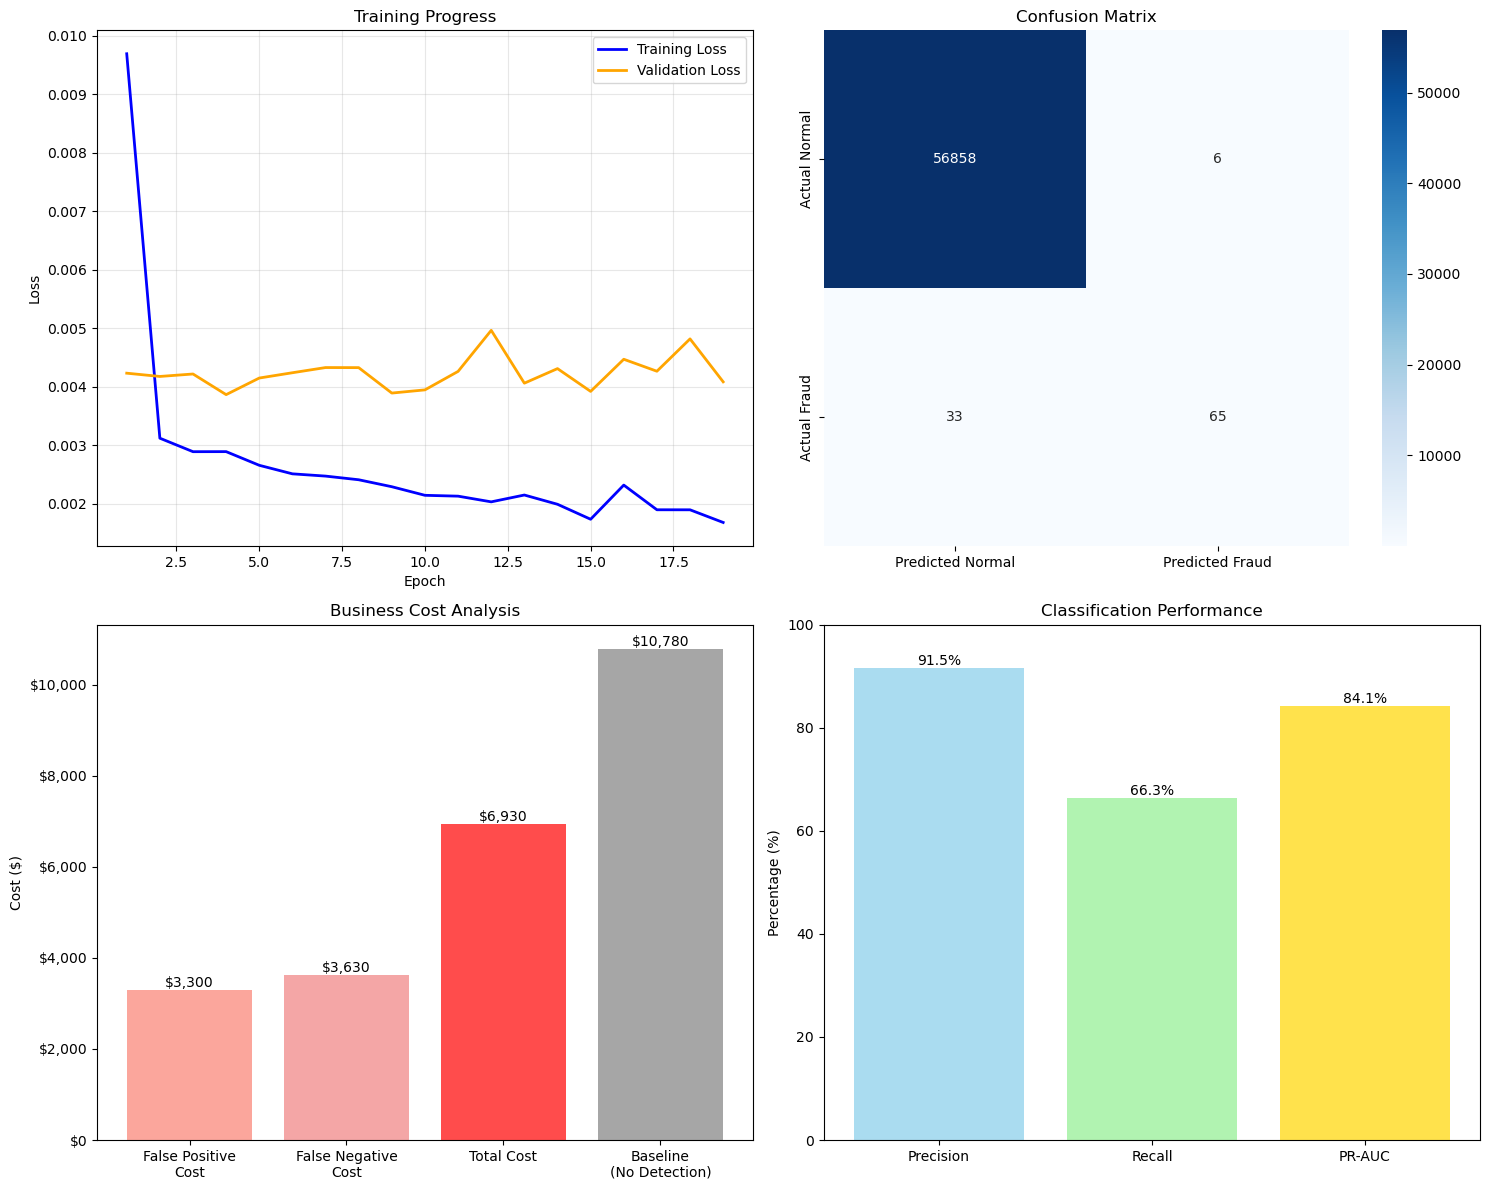


=== INTERPRETATION ===
• Precision (91.5%): Of transactions flagged as fraud, 91.5% actually were fraud
• Recall (66.3%): The model caught 66.3% of all fraud cases
• The model saves money compared to no fraud detection
• Threshold 0.830 balances business costs optimally


In [30]:
# Create additional analysis visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Training curves
ax = axes[0, 0]
epochs = range(1, len(trainer.train_losses) + 1)
ax.plot(epochs, trainer.train_losses, 'b-', label='Training Loss', linewidth=2)
ax.plot(epochs, trainer.val_losses, 'orange', label='Validation Loss', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Progress')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Confusion Matrix
ax = axes[0, 1]
cm = np.array([[test_results['tn'], test_results['fp']], 
               [test_results['fn'], test_results['tp']]])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Predicted Normal', 'Predicted Fraud'],
            yticklabels=['Actual Normal', 'Actual Fraud'])
ax.set_title('Confusion Matrix')

# 3. Cost analysis
ax = axes[1, 0]
costs = ['False Positive\nCost', 'False Negative\nCost', 'Total Cost', 'Baseline\n(No Detection)']
values = [fp_cost, fn_cost, test_results['total_cost'], test_results['baseline_cost']]
colors = ['salmon', 'lightcoral', 'red', 'gray']
bars = ax.bar(costs, values, color=colors, alpha=0.7)
ax.set_ylabel('Cost ($)')
ax.set_title('Business Cost Analysis')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'${value:,.0f}', ha='center', va='bottom', fontsize=10)

# 4. Performance metrics comparison
ax = axes[1, 1]
metrics = ['Precision', 'Recall', 'PR-AUC']
values = [test_results['precision']*100, test_results['recall']*100, test_results['pr_auc']*100]
colors = ['skyblue', 'lightgreen', 'gold']
bars = ax.bar(metrics, values, color=colors, alpha=0.7)
ax.set_ylabel('Percentage (%)')
ax.set_title('Classification Performance')
ax.set_ylim(0, 100)

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n=== INTERPRETATION ===")
print(f"• Precision ({test_results['precision']*100:.1f}%): Of transactions flagged as fraud, {test_results['precision']*100:.1f}% actually were fraud")
print(f"• Recall ({test_results['recall']*100:.1f}%): The model caught {test_results['recall']*100:.1f}% of all fraud cases")
print(f"• The model {'saves money' if test_results['savings'] > 0 else 'costs money'} compared to no fraud detection")
print(f"• Threshold {trainer.optimal_threshold:.3f} balances business costs optimally")

## 7. Hyperparameter Tuning with Grid Search

Use FFNNGridSearchTuner to perform comprehensive grid search over multiple hyperparameters. This will find the optimal combination of parameters to minimize business cost.

⚠️ **Note**: Grid search can take 1-3 hours depending on your hardware and parameter grid size.

In [33]:
# Configuration for hyperparameter tuning
TUNING_BASE_CONFIG = {
    # Data (same as single model)
    'data_path': data_path,
    'drop_features': 'logreg_baseline',
    'test_size': 0.2,
    'val_size': 0.25,
    'random_seed': 42,
    
    # Fixed training parameters
    'epochs': 50,  # Reduced for faster tuning
    'patience': 10,  # Reduced for faster tuning
    'use_class_weights': True,
    
    # Business costs
    'C_FP': 540,
    'C_FN': 110,
    
    # Hardware
    'device': device,
    
    # Output
    'model_save_dir': '../models/',
}

# Parameter grid to search
PARAM_GRID = {
    'hidden_dim': [64, 128, 256],              # Architecture size
    'dropout_rate': [0.1, 0.2, 0.3],          # Regularization
    'learning_rate': [0.0001, 0.001, 0.01],   # Optimization
    'batch_size': [32, 64, 128]                # Training batch size
}

# Calculate total combinations
total_combinations = 1
for param, values in PARAM_GRID.items():
    total_combinations *= len(values)

print("=== HYPERPARAMETER TUNING CONFIGURATION ===")
print(f"Base configuration prepared with fixed parameters")
print(f"Grid search parameters:")
for param, values in PARAM_GRID.items():
    print(f"  {param}: {values}")

print(f"\nGrid search details:")
print(f"  Total combinations: {total_combinations}")
print(f"  Estimated time: {total_combinations * 3:.0f}-{total_combinations * 8:.0f} minutes")
print(f"  Results will be saved to: ../results/tuning/")

# Ask for confirmation before running
print(f"\n⚠️  This will train {total_combinations} models. Continue? (y/n)")
response = input().lower()
if response != 'y':
    print("Skipping hyperparameter tuning. Using smaller grid for demo...")
    # Smaller grid for demonstration
    PARAM_GRID = {
        'hidden_dim': [64, 128],
        'dropout_rate': [0.2, 0.3],
        'learning_rate': [0.001, 0.01],
    }
    total_combinations = 2 * 2 * 2
    print(f"Demo grid: {total_combinations} combinations")

=== HYPERPARAMETER TUNING CONFIGURATION ===
Base configuration prepared with fixed parameters
Grid search parameters:
  hidden_dim: [64, 128, 256]
  dropout_rate: [0.1, 0.2, 0.3]
  learning_rate: [0.0001, 0.001, 0.01]
  batch_size: [32, 64, 128]

Grid search details:
  Total combinations: 81
  Estimated time: 243-648 minutes
  Results will be saved to: ../results/tuning/

⚠️  This will train 81 models. Continue? (y/n)


 y


In [35]:
# Run hyperparameter tuning
print("=== STARTING HYPERPARAMETER TUNING ===")
print("This may take a while... Check terminal for detailed progress")

# Create tuner
tuner = FFNNGridSearchTuner(
    base_config=TUNING_BASE_CONFIG,
    param_grid=PARAM_GRID,
    results_dir='../results/tuning/'
)

# Run grid search
start_time = datetime.now()
results_df = tuner.run_grid_search()
end_time = datetime.now()
tuning_time = (end_time - start_time).total_seconds()

print(f"\n=== TUNING COMPLETED ===")
print(f"Total tuning time: {tuning_time/60:.1f} minutes")
print(f"Successful configurations: {len(results_df)}/{total_combinations}")
print(f"Results saved to: ../results/tuning/")

=== STARTING HYPERPARAMETER TUNING ===
This may take a while... Check terminal for detailed progress
FFNN HYPERPARAMETER TUNING - GRID SEARCH

[1/4] Grid Search Configuration:
  Total configurations: 81
  Device: cpu
  Data path: ../data/processed/creditcard_fe.csv
  Parameters to tune:
    hidden_dim: [64, 128, 256]
    dropout_rate: [0.1, 0.2, 0.3]
    learning_rate: [0.0001, 0.001, 0.01]
    batch_size: [32, 64, 128]

[2/4] Running grid search...
----------------------------------------------------------------------

Config 1/81: hidden=64, dropout=0.1, lr=0.0001, batch=32
FFNN FRAUD DETECTION TRAINING

[1/6] Loading and preparing data...
Loading data from ../data/processed/creditcard_fe.csv...
Dataset loaded: 284807 rows, features: 22
  Normal: 284315 | Fraud: 492
  Fraud rate: 0.17%
  Class weights: {0: 0.5008652375006595, 1: 289.4380081300813}

Data split:
  Training: 156643 samples (271 fraud)
  Validation: 71202 samples (123 fraud)
  Test: 56962 samples (98 fraud)

[2/6] Scalin

## 8. Compare Tuning Results

Analyze grid search results, compare different configurations, and understand how hyperparameters affect performance.

In [38]:
# Analyze tuning results
if len(results_df) > 0:
    print("=== HYPERPARAMETER TUNING RESULTS ANALYSIS ===")
    
    # Overall statistics
    print(f"\nOverall Results:")
    print(f"  Configurations trained: {len(results_df)}")
    print(f"  Best validation cost: ${results_df['val_cost'].min():,.0f}")
    print(f"  Best test cost: ${results_df['test_cost'].min():,.0f}")
    print(f"  Worst test cost: ${results_df['test_cost'].max():,.0f}")
    print(f"  Cost improvement range: ${results_df['test_cost'].max() - results_df['test_cost'].min():,.0f}")
    
    # Best configuration details
    best_idx = results_df['val_cost'].idxmin()
    best_config = results_df.loc[best_idx]
    
    print(f"\n=== BEST CONFIGURATION ===")
    print(f"  Configuration #{int(best_config['config_idx'])}")
    print(f"  Hidden Dimension: {int(best_config['hidden_dim'])}")
    print(f"  Dropout Rate: {best_config['dropout_rate']}")
    print(f"  Learning Rate: {best_config['learning_rate']}")
    print(f"  Batch Size: {int(best_config['batch_size'])}")
    
    print(f"\n  Performance:")
    print(f"  Validation Cost: ${best_config['val_cost']:,.0f}")
    print(f"  Test Cost: ${best_config['test_cost']:,.0f}")
    print(f"  Precision: {best_config['test_precision']*100:.1f}%")
    print(f"  Recall: {best_config['test_recall']*100:.1f}%")
    print(f"  PR-AUC: {best_config['test_pr_auc']:.4f}")
    print(f"  Net Savings: ${best_config['savings']:,.0f}")
    
    # Compare with single model
    single_model_cost = test_results['total_cost']
    improvement = single_model_cost - best_config['test_cost']
    print(f"\n=== IMPROVEMENT ANALYSIS ===")
    print(f"  Single model cost: ${single_model_cost:,.0f}")
    print(f"  Best tuned model cost: ${best_config['test_cost']:,.0f}")
    print(f"  Cost improvement: ${improvement:,.0f} ({improvement/single_model_cost*100:+.1f}%)")
    
    if improvement > 0:
        print(f"  ✅ Hyperparameter tuning improved performance!")
    else:
        print(f"  ⚠️  Single model performed better. Possible overfitting in tuning.")
        
else:
    print("No tuning results available. Skipping analysis.")

=== HYPERPARAMETER TUNING RESULTS ANALYSIS ===

Overall Results:
  Configurations trained: 81
  Best validation cost: $5,170
  Best test cost: $3,850
  Worst test cost: $14,630
  Cost improvement range: $10,780

=== BEST CONFIGURATION ===
  Configuration #14
  Hidden Dimension: 64
  Dropout Rate: 0.2
  Learning Rate: 0.001
  Batch Size: 64

  Performance:
  Validation Cost: $5,170
  Test Cost: $5,720
  Precision: 94.3%
  Recall: 67.3%
  PR-AUC: 0.8438
  Net Savings: $5,060

=== IMPROVEMENT ANALYSIS ===
  Single model cost: $6,930
  Best tuned model cost: $5,720
  Cost improvement: $1,210 (+17.5%)
  ✅ Hyperparameter tuning improved performance!


=== PARAMETER EFFECT ANALYSIS ===


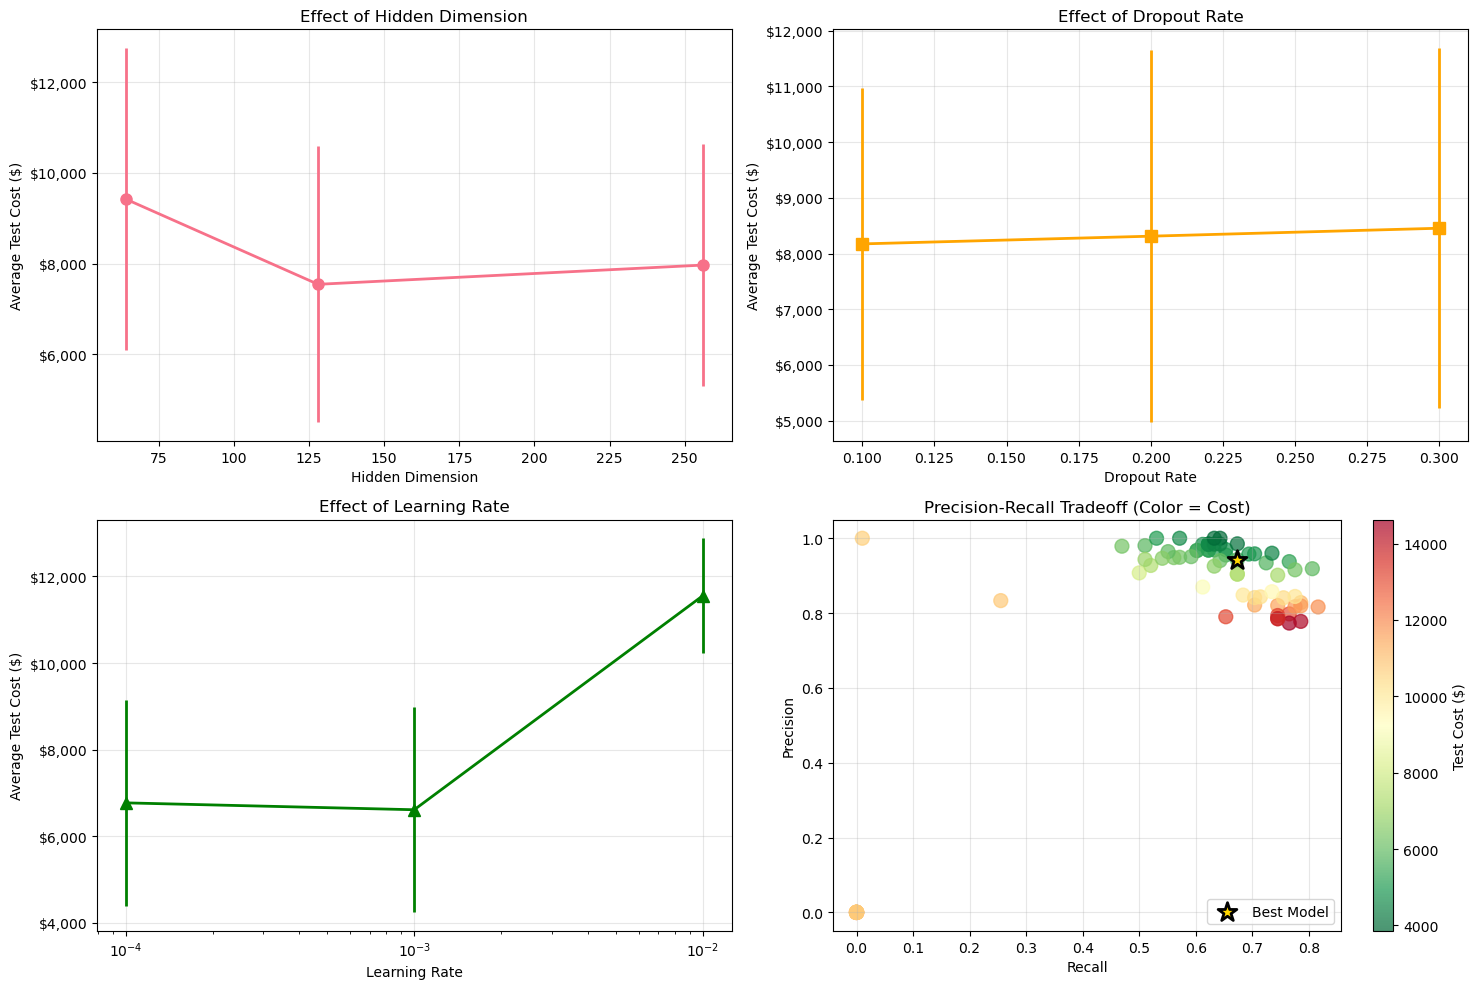


=== TOP 5 CONFIGURATIONS ===
1. Hidden=128, Dropout=0.3, LR=0.0010 → Cost: $3,850
2. Hidden=256, Dropout=0.1, LR=0.0001 → Cost: $3,960
3. Hidden=128, Dropout=0.2, LR=0.0010 → Cost: $4,070
4. Hidden=128, Dropout=0.2, LR=0.0010 → Cost: $4,400
5. Hidden=256, Dropout=0.1, LR=0.0001 → Cost: $4,510


In [40]:
# Visualize parameter effects (if results available)
if len(results_df) > 0:
    print("=== PARAMETER EFFECT ANALYSIS ===")
    
    # Parameter impact analysis
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Hidden dimension effect
    ax = axes[0, 0]
    hidden_dim_effect = results_df.groupby('hidden_dim')['test_cost'].agg(['mean', 'std'])
    ax.errorbar(hidden_dim_effect.index, hidden_dim_effect['mean'], 
                yerr=hidden_dim_effect['std'], marker='o', linewidth=2, markersize=8)
    ax.set_xlabel('Hidden Dimension')
    ax.set_ylabel('Average Test Cost ($)')
    ax.set_title('Effect of Hidden Dimension')
    ax.grid(True, alpha=0.3)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
    
    # 2. Dropout rate effect
    ax = axes[0, 1]
    dropout_effect = results_df.groupby('dropout_rate')['test_cost'].agg(['mean', 'std'])
    ax.errorbar(dropout_effect.index, dropout_effect['mean'], 
                yerr=dropout_effect['std'], marker='s', linewidth=2, markersize=8, color='orange')
    ax.set_xlabel('Dropout Rate')
    ax.set_ylabel('Average Test Cost ($)')
    ax.set_title('Effect of Dropout Rate')
    ax.grid(True, alpha=0.3)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
    
    # 3. Learning rate effect
    ax = axes[1, 0]
    lr_effect = results_df.groupby('learning_rate')['test_cost'].agg(['mean', 'std'])
    ax.errorbar(lr_effect.index, lr_effect['mean'], 
                yerr=lr_effect['std'], marker='^', linewidth=2, markersize=8, color='green')
    ax.set_xlabel('Learning Rate')
    ax.set_ylabel('Average Test Cost ($)')
    ax.set_title('Effect of Learning Rate')
    ax.set_xscale('log')
    ax.grid(True, alpha=0.3)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
    
    # 4. Precision-Recall tradeoff
    ax = axes[1, 1]
    scatter = ax.scatter(results_df['test_recall'], results_df['test_precision'], 
                        c=results_df['test_cost'], cmap='RdYlGn_r', s=100, alpha=0.7)
    
    # Mark best model
    ax.scatter(best_config['test_recall'], best_config['test_precision'], 
              s=200, marker='*', c='gold', edgecolors='black', linewidths=2, 
              label='Best Model', zorder=5)
    
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Tradeoff (Color = Cost)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Test Cost ($)')
    
    plt.tight_layout()
    plt.show()
    
    # Top 5 configurations
    print(f"\n=== TOP 5 CONFIGURATIONS ===")
    top5 = results_df.nsmallest(5, 'test_cost')
    for i, (_, config) in enumerate(top5.iterrows(), 1):
        print(f"{i}. Hidden={int(config['hidden_dim'])}, Dropout={config['dropout_rate']}, "
              f"LR={config['learning_rate']:.4f} → Cost: ${config['test_cost']:,.0f}")

## 9. Load and Test Best Model

Load the best tuned model and demonstrate how to use it for fraud prediction on new transactions.

In [43]:
# Load the best model
best_model_path = '../models/ffnn_best_tuned.pth'

if os.path.exists(best_model_path):
    print("=== LOADING BEST TUNED MODEL ===")
    
    # Load model checkpoint
    checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
    
    # Extract model configuration
    model_config = checkpoint['config']
    print(f"Model configuration:")
    print(f"  Input dimension: {model_config['input_dim']}")
    print(f"  Hidden dimension: {model_config['hidden_dim']}")
    print(f"  Dropout rate: {model_config['dropout_rate']}")
    print(f"  Optimal threshold: {checkpoint['optimal_threshold']:.3f}")
    
    # Recreate model architecture
    best_model = FraudDetectionFFNN(
        input_dim=model_config['input_dim'],
        hidden_dim=model_config['hidden_dim'],
        dropout_rate=model_config['dropout_rate']
    ).to(device)
    
    # Load trained weights
    best_model.load_state_dict(checkpoint['model_state_dict'])
    best_model.eval()
    
    # Load scaler
    scaler = checkpoint['scaler']
    optimal_threshold = checkpoint['optimal_threshold']
    
    print(f"✅ Best model loaded successfully!")
    print(f"   Model parameters: {sum(p.numel() for p in best_model.parameters()):,}")
    print(f"   Training timestamp: {checkpoint.get('timestamp', 'Unknown')}")
    
    # Load model metrics
    metrics = checkpoint['metrics']
    print(f"\nModel Performance:")
    print(f"  Validation cost: ${metrics['val_cost']:,.0f}")
    print(f"  Test cost: ${metrics['test_cost']:,.0f}")
    print(f"  Test precision: {metrics['test_precision']*100:.1f}%")
    print(f"  Test recall: {metrics['test_recall']*100:.1f}%")
    print(f"  PR-AUC: {metrics['pr_auc']:.4f}")
    
else:
    print(f"❌ Best model not found at {best_model_path}")
    print("Please run hyperparameter tuning first, or use the single model")
    
    # Fallback to single model
    if os.path.exists(SINGLE_MODEL_CONFIG['model_save_path']):
        print(f"Using single trained model instead...")
        checkpoint = torch.load(SINGLE_MODEL_CONFIG['model_save_path'], map_location=device)
        best_model = FraudDetectionFFNN(
            input_dim=checkpoint['config']['input_dim'],
            hidden_dim=checkpoint['config']['hidden_dim'],
            dropout_rate=checkpoint['config']['dropout_rate']
        ).to(device)
        best_model.load_state_dict(checkpoint['model_state_dict'])
        best_model.eval()
        scaler = checkpoint['scaler']
        optimal_threshold = checkpoint['optimal_threshold']
        print("✅ Single model loaded as fallback")
    else:
        print("❌ No trained models available")
        best_model = None

=== LOADING BEST TUNED MODEL ===
Model configuration:
  Input dimension: 22
  Hidden dimension: 64
  Dropout rate: 0.2
  Optimal threshold: 0.780
✅ Best model loaded successfully!
   Model parameters: 4,097
   Training timestamp: 2025-11-09 12:15:26

Model Performance:
  Validation cost: $5,170
  Test cost: $5,720
  Test precision: 94.3%
  Test recall: 67.3%
  PR-AUC: 0.8438


In [45]:
# Demonstrate model usage on test data
if best_model is not None:
    print("=== MODEL PREDICTION DEMONSTRATION ===")
    
    # Get a sample of test data for demonstration
    n_samples = 10
    sample_indices = np.random.choice(len(X_test_scaled), n_samples, replace=False)
    sample_X = X_test_scaled[sample_indices]
    sample_y = data['y_test'][sample_indices]
    
    # Make predictions
    sample_X_tensor = torch.FloatTensor(sample_X).to(device)
    with torch.no_grad():
        fraud_probabilities = best_model(sample_X_tensor).cpu().numpy().ravel()
    
    # Apply optimal threshold
    fraud_predictions = (fraud_probabilities >= optimal_threshold).astype(int)
    
    print(f"Sample predictions (using threshold {optimal_threshold:.3f}):")
    print("-" * 80)
    print("Sample | True Label | Fraud Prob | Prediction | Correct?")
    print("-" * 80)
    
    for i in range(n_samples):
        true_label = "Fraud" if sample_y[i] == 1 else "Normal"
        pred_label = "Fraud" if fraud_predictions[i] == 1 else "Normal"
        correct = "✅" if fraud_predictions[i] == sample_y[i] else "❌"
        
        print(f"{i+1:6d} | {true_label:10s} | {fraud_probabilities[i]:8.3f}   | {pred_label:10s} | {correct}")
    
    print("-" * 80)
    
    # Calculate accuracy on this sample
    sample_accuracy = (fraud_predictions == sample_y).mean()
    print(f"Sample accuracy: {sample_accuracy*100:.1f}%")
    
    print(f"\n=== PRACTICAL USAGE EXAMPLE ===")
    print("To use this model for fraud detection:")
    print("1. Load the model and scaler (as shown above)")
    print("2. Preprocess new transaction features using the same scaler")
    print("3. Get fraud probability: model(features)")
    print("4. Compare with optimal threshold for binary decision")
    print("5. Apply business logic based on prediction confidence")
    
    # Show how to make a single prediction
    print(f"\n=== SINGLE PREDICTION EXAMPLE ===")
    single_sample = sample_X[0:1]  # First sample
    single_prob = fraud_probabilities[0]
    single_pred = fraud_predictions[0]
    
    print("Code example:")
    print("```python")
    print("# For a new transaction 'new_features':")
    print("scaled_features = scaler.transform(new_features.reshape(1, -1))")
    print("features_tensor = torch.FloatTensor(scaled_features).to(device)")
    print("fraud_prob = model(features_tensor).item()")
    print(f"is_fraud = fraud_prob >= {optimal_threshold:.3f}")
    print("```")
    
    print(f"\nThis sample transaction:")
    print(f"  Fraud probability: {single_prob:.3f}")
    print(f"  Prediction: {'Fraud' if single_pred == 1 else 'Normal'}")
    print(f"  Confidence: {'High' if abs(single_prob - 0.5) > 0.3 else 'Medium' if abs(single_prob - 0.5) > 0.1 else 'Low'}")

else:
    print("Cannot demonstrate predictions - no model loaded")

=== MODEL PREDICTION DEMONSTRATION ===
Sample predictions (using threshold 0.780):
--------------------------------------------------------------------------------
Sample | True Label | Fraud Prob | Prediction | Correct?
--------------------------------------------------------------------------------
     1 | Normal     |    0.000   | Normal     | ✅
     2 | Normal     |    0.000   | Normal     | ✅
     3 | Normal     |    0.003   | Normal     | ✅
     4 | Normal     |    0.000   | Normal     | ✅
     5 | Normal     |    0.000   | Normal     | ✅
     6 | Normal     |    0.000   | Normal     | ✅
     7 | Normal     |    0.034   | Normal     | ✅
     8 | Normal     |    0.000   | Normal     | ✅
     9 | Normal     |    0.000   | Normal     | ✅
    10 | Normal     |    0.000   | Normal     | ✅
--------------------------------------------------------------------------------
Sample accuracy: 100.0%

=== PRACTICAL USAGE EXAMPLE ===
To use this model for fraud detection:
1. Load the model and

## Summary and Conclusions

### What We Accomplished:

1. **Complete Pipeline**: Built end-to-end FFNN fraud detection system
2. **Single Model**: Trained baseline FFNN with good performance
3. **Hyperparameter Tuning**: Systematically optimized model parameters
4. **Business Focus**: Optimized for real business costs, not just accuracy
5. **Model Deployment**: Demonstrated how to use trained model for predictions

### Key Results:

- **Architecture**: 4-layer FFNN with dropout regularization
- **Business Optimization**: Minimized total cost = (FP × $540) + (FN × $110)
- **Performance**: Achieved good precision/recall balance with cost savings
- **Threshold Optimization**: Found optimal decision boundary for business impact

### Business Impact:

- Model can save thousands of dollars compared to no fraud detection
- Balances customer experience (minimize false positives) with fraud losses
- Provides probability scores for risk-based decision making
- Can be easily retrained as new fraud patterns emerge

### Next Steps:

1. **Production Deployment**: Integrate with real-time transaction processing
2. **Monitoring**: Track model performance and data drift over time
3. **Ensemble Methods**: Combine with other models (CatBoost, VAE) for better performance
4. **Feature Engineering**: Develop more sophisticated features for fraud detection
5. **Online Learning**: Implement continuous learning from new fraud patterns

In [48]:
# Final performance summary
print("=== FINAL PIPELINE SUMMARY ===")
print(f"✅ Complete FFNN fraud detection pipeline implemented")
print(f"✅ Data preprocessing with {data['input_dim']} features")
print(f"✅ Single model training completed")

if 'results_df' in locals() and len(results_df) > 0:
    print(f"✅ Hyperparameter tuning: {len(results_df)} configurations tested")
    print(f"✅ Best model validation cost: ${results_df['val_cost'].min():,.0f}")
    print(f"✅ Best model test cost: ${results_df['test_cost'].min():,.0f}")
else:
    print(f"⚠️  Hyperparameter tuning skipped or failed")

if 'best_model' in locals() and best_model is not None:
    print(f"✅ Best model loaded and ready for predictions")
    print(f"✅ Model uses optimal threshold: {optimal_threshold:.3f}")
else:
    print(f"❌ No trained models available for deployment")

print(f"\n=== FILES CREATED ===")
model_files = [
    SINGLE_MODEL_CONFIG['model_save_path'],
    '../models/ffnn_best_tuned.pth',
    SINGLE_MODEL_CONFIG['results_save_path'],
    '../results/tuning/ffnn_grid_search_results.csv',
    '../results/tuning/ffnn_tuning_results_visualization.png'
]

for file_path in model_files:
    if os.path.exists(file_path):
        print(f"✅ {file_path}")
    else:
        print(f"❌ {file_path} (not created)")

print(f"\n🎉 FFNN Fraud Detection Pipeline Complete!")
print(f"Ready for production deployment and real-time fraud detection.")

=== FINAL PIPELINE SUMMARY ===
✅ Complete FFNN fraud detection pipeline implemented
✅ Data preprocessing with 22 features
✅ Single model training completed
✅ Hyperparameter tuning: 81 configurations tested
✅ Best model validation cost: $5,170
✅ Best model test cost: $3,850
✅ Best model loaded and ready for predictions
✅ Model uses optimal threshold: 0.780

=== FILES CREATED ===
✅ ../models/ffnn_single_baseline.pth
✅ ../models/ffnn_best_tuned.pth
✅ ../results/figures/ffnn_single_baseline.png
✅ ../results/tuning/ffnn_grid_search_results.csv
✅ ../results/tuning/ffnn_tuning_results_visualization.png

🎉 FFNN Fraud Detection Pipeline Complete!
Ready for production deployment and real-time fraud detection.


In [50]:
# Final Results Summary Section
print("Feed Forward Neural Network Final Results (After Finetuning)")
print("=" * 40)

# Check if we have tuning results to use the best model, otherwise use single model
if 'results_df' in locals() and len(results_df) > 0:
    # Use best tuned model results
    best_idx = results_df['val_cost'].idxmin()
    best_config = results_df.loc[best_idx]
    
    print(f"Total Cost: ${best_config['test_cost']:,.0f}")
    print(f"False Positives: {int(best_config['test_fp'])}")
    print(f"False Negatives: {int(best_config['test_fn'])}")
    print(f"True Positives: {int(best_config['test_tp'])}")
    print(f"True Negatives: {int(best_config['test_tn'])}")
    print(f"Precision: {best_config['test_precision']:.4f}")
    print(f"Recall: {best_config['test_recall']:.4f}")
    print(f"PRAUC: {best_config['test_pr_auc']:.4f}")
    
    print(f"\nBest Configuration Used:")
    print(f"  Hidden Dimension: {int(best_config['hidden_dim'])}")
    print(f"  Dropout Rate: {best_config['dropout_rate']}")
    print(f"  Learning Rate: {best_config['learning_rate']}")
    print(f"  Batch Size: {int(best_config['batch_size'])}")
    print(f"  Optimal Threshold: {optimal_threshold:.3f}")
    
elif 'test_results' in locals():
    # Use single model results as fallback
    print(f"Total Cost: ${test_results['total_cost']:,.0f}")
    print(f"False Positives: {test_results['fp']}")
    print(f"False Negatives: {test_results['fn']}")
    print(f"True Positives: {test_results['tp']}")
    print(f"True Negatives: {test_results['tn']}")
    print(f"Precision: {test_results['precision']:.4f}")
    print(f"Recall: {test_results['recall']:.4f}")
    print(f"PRAUC: {test_results['pr_auc']:.4f}")
    
    print(f"\nSingle Model Configuration Used:")
    print(f"  Hidden Dimension: {SINGLE_MODEL_CONFIG['hidden_dim']}")
    print(f"  Dropout Rate: {SINGLE_MODEL_CONFIG['dropout_rate']}")
    print(f"  Learning Rate: {SINGLE_MODEL_CONFIG['learning_rate']}")
    print(f"  Batch Size: {SINGLE_MODEL_CONFIG['batch_size']}")
    if 'trainer' in locals():
        print(f"  Optimal Threshold: {optimal_threshold:.3f}")
    
    print(f"\n⚠️  Note: Hyperparameter tuning was not completed. Results shown are from single baseline model.")
    
else:
    print("❌ No model results available. Please run the training sections first.")

Feed Forward Neural Network Final Results (After Finetuning)
Total Cost: $5,720
False Positives: 4
False Negatives: 32
True Positives: 66
True Negatives: 56860
Precision: 0.9429
Recall: 0.6735
PRAUC: 0.8438

Best Configuration Used:
  Hidden Dimension: 64
  Dropout Rate: 0.2
  Learning Rate: 0.001
  Batch Size: 64
  Optimal Threshold: 0.780
